# CQF Exam Two

## January 2024 Cohort

## Task (copied from the exam sheet)

Use the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$

$$
V(S, t) = e^{-r(T-t)} \mathbb{E}^\mathbb{Q}\left[\textbf{Payoff}(S_T)\right]
$$

for the appropriate form of payoff, to consider **Asian** and **Lookback** options.

Use the **Euler-Maruyama** (only) scheme for initially simulating the underlying stock price. As an initial example you may use the following set of sample data:

\begin{align*}
\text{Today's stock price } S_0 & = 100 \\
\text{Strike } E & = 100 \\
\text{Time to expiry } (T - t) & = 1 \text{ year} \\
\text{Volatility } \sigma & = 20\% \\
\text{Constant risk-free interest rate } r & = 5\%
\end{align*}

Then vary the data to see the affect on the option price.

## Solution

### 1 Mathematical formulation

Under risk neutrality, we assume the underlying stock price process $S_t$ follows a Geometric Brownian motion

$$dS_t = rS_t dt + \sigma S_t dW_t,$$

where $S_t$ is the price of the underlying at time $t$, $\sigma$ is constant volatility, $r$ is the constant risk-free interest rate, and $W_t$ is the Brownian motion.

Following [1] + [2], Euler-Maruyama method discretizes the process $S_t$ over the time steps $\delta t$ in the time interval $0 < \delta t < T$ to

$$S(t+\delta t) = S(t) * \left(1+ r\delta t+\sigma  \sqrt{\delta t}\phi\right),$$

where $\phi$ is from a standardized Normal distribution. But since our SDE for the asset path is integrable, we can find the time-stepping algorithm

$$S(t+\delta t) = S(t) * \exp\left[\left(r-\frac{1}{2}\sigma^2\right)\delta t + \sigma\sqrt{\delta t}\phi\right],$$

which is what we will implement in the following.

In [193]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


np.set_printoptions(precision=3)
pd.set_option('display.precision', 4)
warnings.filterwarnings('ignore')

In [194]:
S0 = 100
K = 100  # using K for strike seems more natural for me, so I named this variable K
t = 1
sigma = 0.2
r = 0.05
dt = 0.01
number_of_mc_paths = 50000

### 2 Generate price paths

Now generate $N=50k$ Monte Carlo asset paths using the discretized time-stepping algorithm for Geometric Brownian motion and store these asset simulations in an array S. Each of these 50k simulations of S will contain $(T-t)/0.01 = 100$ stock prices for each time step $\delta t$ over the course of the observation period until the derivative options expire.

It makes sense to have a high number of Monte Carlo paths (in this case: $N=50000$), because the sources in the Monte Carlo pricing method are of order $\mathcal{O}(N^{-0.5})$. The time step size $\delta t$ should also be chosen as small as possible, since the discretization of continuous events always introduces some imprecisions of order $\mathcal{O}(\delta t)$.

In [195]:
def simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths=10000):
    """Simulate stock price using Euler-Maruyama method."""
    N = int(t / dt)  # number of time steps
    S = np.zeros((number_of_mc_paths, N))
    S[:, 0] = S0
    for i in range(1, N):
        dW = np.random.standard_normal(number_of_mc_paths)  # Brownian increment
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * dW)  # Euler-Maruyama step
    return S


S = simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths)
# S is an array with length = <number_of_mc_paths> containing the simulated asset prices
S

array([[100.   , 101.048, 101.807, ..., 140.721, 140.038, 140.684],
       [100.   , 101.74 , 101.861, ..., 115.669, 116.833, 116.408],
       [100.   , 100.866, 100.619, ...,  98.873, 100.835,  99.573],
       ...,
       [100.   ,  98.539,  98.963, ..., 100.564, 100.663,  95.222],
       [100.   ,  99.112,  99.105, ..., 114.118, 116.872, 115.738],
       [100.   , 100.982, 101.227, ..., 143.804, 142.062, 140.33 ]])

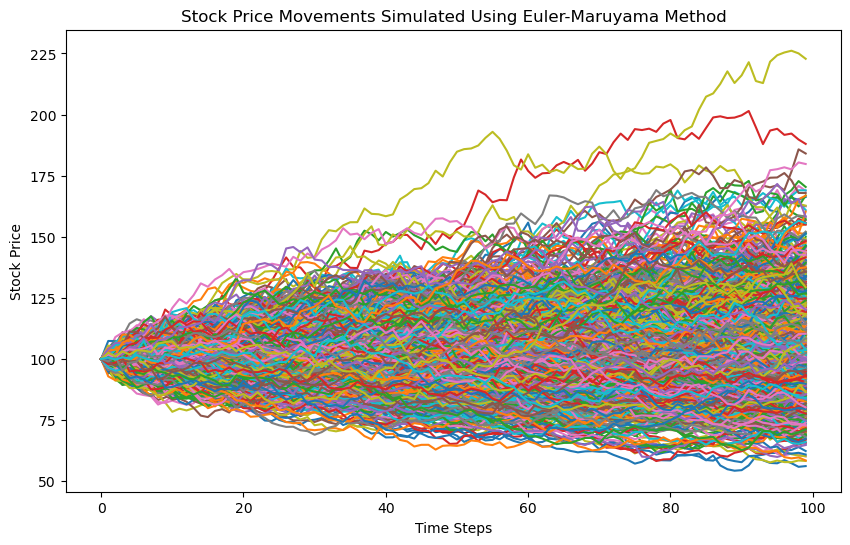

In [196]:
plt.figure(figsize=(10, 6))
for i in range(1000):  # plot the first 1000 paths
    plt.plot(S[i, :])
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Movements Simulated Using Euler-Maruyama Method')
plt.show()

### 3 From asset price to option price

With our asset price simulations generated, we can now calculate the option payoff at expiry, i.e. $\textbf{Payoff}(S_T)$, for every path. This yields $N$ option payoffs for each option type. Under risk-neutral measure $\mathbb{Q}$, the option price at any time $0\leq t\leq T$ is the discounted value of the expected payoff we apply the formula, i.e.

$$V(S, t) = e^{-r(T-t)} \mathbb{E}^\mathbb{Q}\left[\textbf{Payoff}(S_T)\right].$$

We will now implement this formula for **Asian options** and **Lookback options**.

##### Asian options
Asian options depend on the average price of the underlying price $S_t$ for $0<t<T$. Denote this average price by $A$. For a fixed strike $E$, the payoff functions are given by
* Asian call payoff = $\max(A-E, 0)$,
* Asian put payoff = $\max(E-A, 0)$.

Asian options with so-called floating strike have payoffs
* Asian call payoff = $\max(S-A, 0)$,
* Asian put payoff = $\max(A-S, 0)$.

The average price over a time interval $[0,T]$ is defined as:
* Continuous average: $$A=\frac{1}{T}\int_0^T S(t) dt,$$
* Discrete average with $0=t_1<...<t_n=T$ with $t_i=i*\delta t$: $$A=\frac{1}{n}\sum_{i=1}^n S(t_i).$$

Since we are discretizing the time interval, we will use the discrete average implementation and any discussion shall regard the discrete functions over the interval $[0,T]$. In fact, infinitesimal implementation is impossible in a real-life situation.
Note that there the described average function is the *arithmetic average*. One could also consider the *geometric average* $A_g$, discretely calculated as: $$A_g=\left(\prod_{i=1}^n S(t_i) \right)^{1/n}$$. For simplicity, we will concentrate our study on discrete arithmetic averaging.

##### Lookback options
Lookback options depend on the maximum price $M$ or minimum price $m$ of the underlying price $S_t$ for $0<t<T$. For a fixed strike $E$, the payoff functions are given by
* Lookback call payoff, fixed strike = $\max(M-E, 0)$
* Lookback put payoff, fixed strike = $\max(E-m, 0)$.

Lookback options with so-called floating strike have payoffs
* Lookback call payoff, floating strike = $\max(S_T-m, 0)=S_T-m$
* Lookback put payoff, floating strike = $\max(M-S_T, 0)=M-S_T$.

In [197]:
def asian_option(S, K, r, t, fixed_strike=1):
    """Calculate Asian call + put option prices by discounting their expected payoffs."""
    avg = np.mean(S, axis=1)  # mean stock price over all simulations
    if fixed_strike:
        asian_call = np.exp(-r * t) * np.maximum(avg - K, 0)
        asian_put = np.exp(-r * t) * np.maximum(K - avg, 0)
    else:  # calculate the option payoffs for floating strike now
        asian_call = np.exp(-r * t) * np.maximum(S[:, -1] - avg, 0)
        asian_put = np.exp(-r * t) * np.maximum(avg - S[:, -1], 0)
    return np.mean(asian_call), np.mean(asian_put)


def lookback_option(S, K, r, t, fixed_strike=1):
    """Calculate Lookback call + put option prices by discounting their expected payoffs."""
    min_S = np.min(S, axis=1)  # minimum stock price over all simulations
    max_S = np.max(S, axis=1)  # maximum stock price over all simulations
    if fixed_strike:
        lookback_call = np.exp(-r * t) * np.maximum(max_S - K, 0)
        lookback_put = np.exp(-r * t) * np.maximum(K - min_S, 0)
    else:  # calculate the option payoffs for floating strike now
        lookback_call = np.exp(-r * t) * np.maximum(S[:, -1] - min_S, 0)
        lookback_put = np.exp(-r * t) * np.maximum(max_S - S[:, -1], 0)
    return np.mean(lookback_call), np.mean(lookback_put)

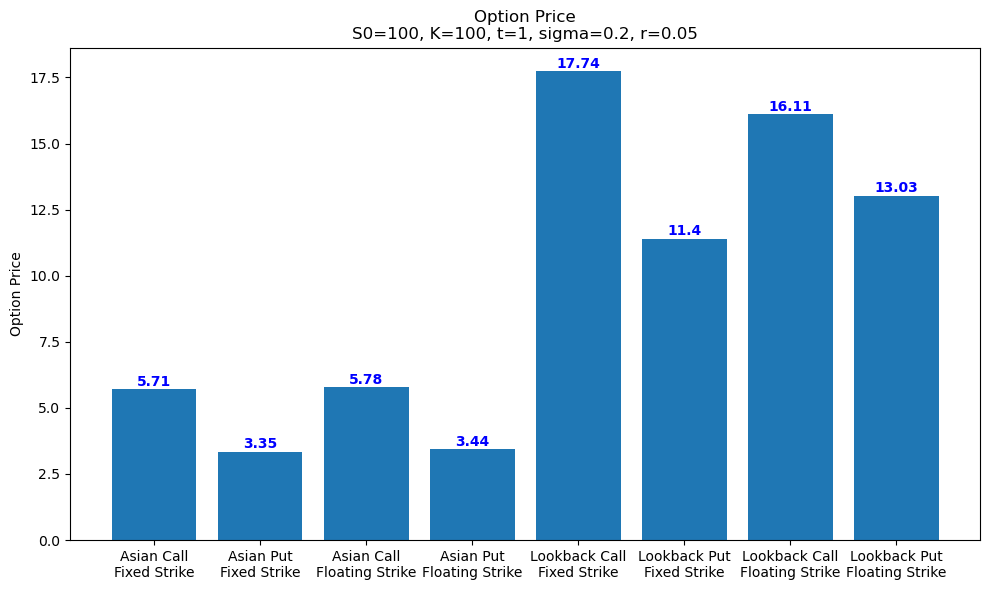

In [199]:
# Calculate option prices + plot them in a bar diagram
asian_fixed_call, asian_fixed_put = asian_option(S, K, r, t, fixed_strike=1)
asian_float_call, asian_float_put = asian_option(S, K, r, t, fixed_strike=0)
lookback_fixed_call, lookback_fixed_put = lookback_option(S, K, r, t, fixed_strike=1)
lookback_float_call, lookback_float_put = lookback_option(S, K, r, t, fixed_strike=0)

plt.figure(figsize=(10, 6))
labels = ['Asian Call\nFixed Strike', 'Asian Put\nFixed Strike',
          'Asian Call\nFloating Strike', 'Asian Put\nFloating Strike',
          'Lookback Call\nFixed Strike', 'Lookback Put\nFixed Strike',
          'Lookback Call\nFloating Strike', 'Lookback Put\nFloating Strike']
prices = [asian_fixed_call, asian_fixed_put, asian_float_call, asian_float_put,
          lookback_fixed_call, lookback_fixed_put, lookback_float_call, lookback_float_put]
bars = plt.bar(labels, prices)

# Annotate bars with prices
for bar in bars:
    option_price = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, option_price + 0.01, round(option_price, 2),
             ha='center', va='bottom', color='blue', weight='bold')

plt.ylabel('Option Price')
plt.title(f'Option Price\nS0={S0}, K={K}, t={t}, sigma={sigma}, r={r}')
plt.xticks()
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()

### 4 Analysis of option prices given $S_0=K=100, T-t=1 year, \sigma=20\%, r=5\%, \delta t=0.01, N=50000$

This plot shows that lookback options (both call and put) are the most expensive to purchase, while the Asian options are cheaper. This can be explained intuitively because the average function is more less volatile and stabilizing than the maximum or minimum functions that the lookback options depend on. Therefore, being able to exercise depending on the maximum or minimum of the stock price over a certain time interval versus on the average on the same time interval has much higher upside potential for the investor which is reflected in the higher prices.

We can also plot the three functions compared to the asset simulations. Note that the maximum and minimum function might look wrong upon first inspection, but we only plot the first 500 simulation paths of $N=50k$ for performance and also visibility of the plot.

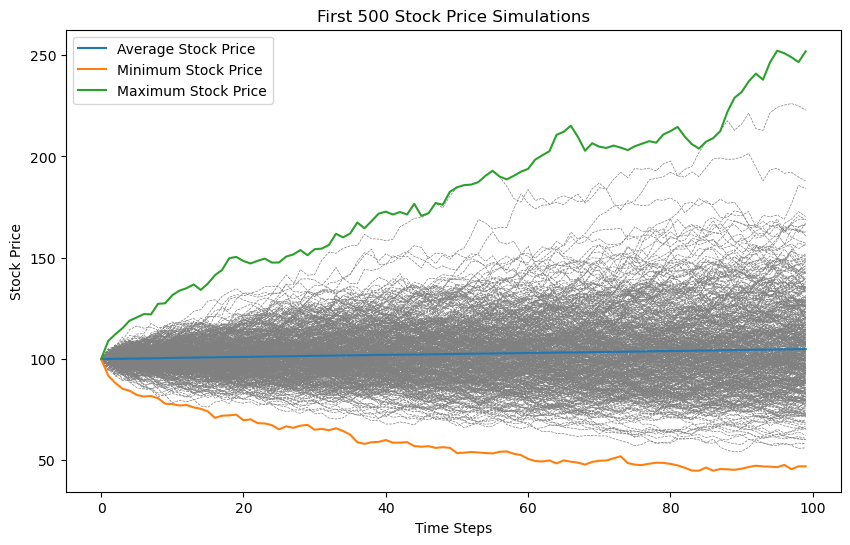

In [200]:
plt.figure(figsize=(10, 6))
for i in range(500):  # plot the first 1000 paths
    plt.plot(S[i, :], color='gray', linewidth=0.5, linestyle='dashed')

# plot other functions of the stock price simulations, like average, min + max
avg_S = np.mean(S, axis=0)
min_S = np.min(S, axis=0)
max_S = np.max(S, axis=0)
plt.plot(avg_S, label='Average Stock Price')
plt.plot(min_S, label='Minimum Stock Price')
plt.plot(max_S, label='Maximum Stock Price')

plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title(f'First 500 Stock Price Simulations')
plt.legend()
plt.show()

### 5 Impact analysis of parameters $S_0,K,T-t,\sigma,r=5\%,\delta t,N$

In the following, let us investigate the impact of each of the parameters:

\begin{align*}
\text{Today's stock price } & S_0\\
\text{Strike } & E\\
\text{Time to expiry } & T - t\\
\text{Volatility } & \sigma\\
\text{Constant risk-free interest rate } & r\\
\text{Number of Monte Carlo Simulations } & N,
\end{align*}

while the other parameters are being held constant. To make things a bit easier for the following, I have grouped all previously written code together in a class that takes above set of parameters and initializes appropriate instance variables and simulates asset paths for every class instantiation.

In [201]:
class OptionPricer:
    def __init__(self, S0, K, r, t, dt, sigma, number_of_mc_paths):
        self.S0 = S0
        self.K = K
        self.r = r
        self.t = t
        self.dt = dt
        self.sigma = sigma
        self.number_of_mc_paths = number_of_mc_paths
        self.S = self.simulate_stock_price()

    def simulate_stock_price(self):
        """Simulate stock price using Euler-Maruyama method."""
        N = int(self.t / self.dt)  # number of time steps
        S = np.zeros((self.number_of_mc_paths, N))
        S[:, 0] = self.S0
        for i in range(1, N):
            dW = np.random.standard_normal(self.number_of_mc_paths)  # Brownian increment
            S[:, i] = S[:, i-1] * np.exp((self.r - 0.5 * self.sigma ** 2) * self.dt + self.sigma * np.sqrt(self.dt) * dW)  # Euler-Maruyama step
        return S

    def asian_option(self, fixed_strike=1):
        """Calculate Asian call + put option prices by discounting their expected payoffs."""
        avg = np.mean(self.S, axis=1)  # mean stock price over all simulations
        if fixed_strike:
            asian_call = np.exp(-self.r * self.t) * np.maximum(avg - self.K, 0)
            asian_put = np.exp(-self.r * self.t) * np.maximum(self.K - avg, 0)
        else:  # calculate the option payoffs for floating strike now
            asian_call = np.exp(-self.r * self.t) * np.maximum(self.S[:, -1] - avg, 0)
            asian_put = np.exp(-self.r * self.t) * np.maximum(avg - self.S[:, -1], 0)
        return np.mean(asian_call), np.mean(asian_put)

    def lookback_option(self, fixed_strike=1):
        """Calculate Lookback call + put option prices by discounting their expected payoffs."""
        min_S = np.min(self.S, axis=1)  # minimum stock price over all simulations
        max_S = np.max(self.S, axis=1)  # maximum stock price over all simulations
        if fixed_strike:
            lookback_call = np.exp(-self.r * self.t) * np.maximum(max_S - self.K, 0)
            lookback_put = np.exp(-self.r * self.t) * np.maximum(self.K - min_S, 0)
        else:  # calculate the option payoffs for floating strike now
            lookback_call = np.exp(-self.r * self.t) * np.maximum(self.S[:, -1] - min_S, 0)
            lookback_put = np.exp(-self.r * self.t) * np.maximum(max_S - self.S[:, -1], 0)
        return np.mean(lookback_call), np.mean(lookback_put)

    def calculate_option_prices(self):
        """Calculate the prices of different options types."""
        # Calculate option prices
        asian_fixed_call, asian_fixed_put = self.asian_option(fixed_strike=1)
        asian_float_call, asian_float_put = self.asian_option(fixed_strike=0)
        lookback_fixed_call, lookback_fixed_put = self.lookback_option(fixed_strike=1)
        lookback_float_call, lookback_float_put = self.lookback_option(fixed_strike=0)
        return asian_fixed_call, asian_fixed_put, asian_float_call, asian_float_put,\
            lookback_fixed_call, lookback_fixed_put, lookback_float_call, lookback_float_put

This function will be used to plot the option prices against the parameters we wish to analyze the impact of.

In [227]:
def plot_option_prices_vs_param(param_name, param_values, option_prices, annotation_precision=2, log_x_axis=False):
    """Plot the option prices for different values of a parameter."""
    plt.figure(figsize=(10, 6))

    # define order of colors for the plots, so option price scatter dot has same color as the connecting line
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'rosybrown']

    for i, prices in enumerate(zip(*option_prices)):  # transpose option_prices list
        for value, price in zip(param_values, prices):
            plt.scatter(value, price, marker='o', color=colors[i])  # plot option price as scatter point
            # add text annotation for each point
            plt.text(value, price, f"{param_name}={str(round(value, annotation_precision))}", fontsize=8)

        # plot connecting lines for the scatter points of each option type, color=... ensures same color is used
        label_list = ['Asian Fixed Call', 'Asian Fixed Put',
                      'Asian Float Call', 'Asian Float Put',
                      'Lookback Fixed Call', 'Lookback Fixed Put',
                      'Lookback Float Call', 'Lookback Float Put']
        plt.plot(param_values, prices, label=label_list[i], color=colors[i])

    plt.xlabel(param_name)
    plt.ylabel('Option Price')
    plt.title(f'Option Prices vs {param_name}')
    if log_x_axis:
        plt.xscale('log')  # set x-axis to logarithmic scale
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))  # legend outside of graphs
    plt.show()

#### 5.1 Impact analysis of number of Monte Carlo paths $N$

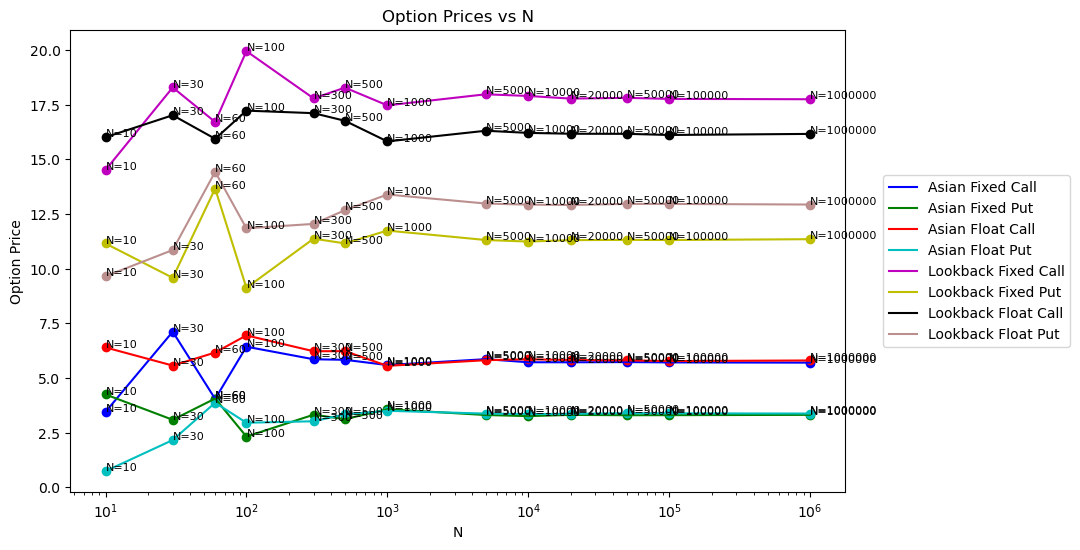

In [240]:
param_name = "N"
param_values = [10, 30, 60, 100, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000, 1000000]
option_prices = []
for param_value in param_values:
    op = OptionPricer(S0=100, K=100, r=0.05, t=1, dt=0.01, sigma=0.2, number_of_mc_paths=param_value)
    option_prices.append(op.calculate_option_prices())
plot_option_prices_vs_param(param_name, param_values, option_prices, log_x_axis=True)

We can see that the option prices start off instable if the number of Monte Carlo paths is chosen low. As $N$ increases, the option prices become more stable and evidently seem to converge sufficiently at around $N=10000$ to $N=20000$. For further testing, we will use $N=20000$ for performance improvement. In fact, optimizing performance was the reason I chose to analyze this parameter first.

The instable numerical behavior for $N<1000$ is not unexpected because the error source stemming from number of simulations is of order $\mathcal{O}(N^{-0.5})$.

#### 5.2 Impact analysis of initial stock value $S_0$

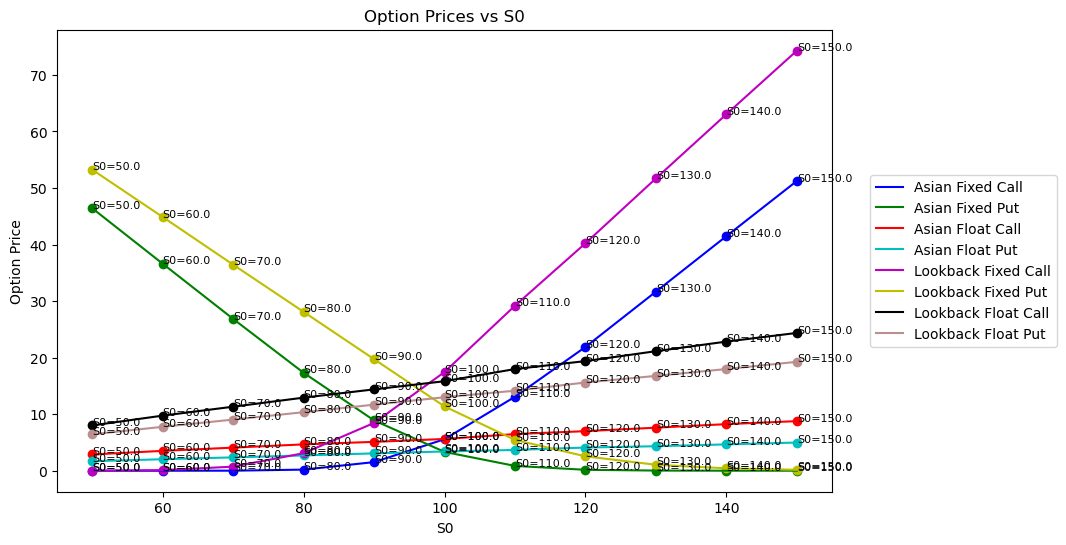

In [246]:
param_name = "S0"
param_values = np.linspace(50, 150, 10+1)  # an equidistant list of 10 values for S0 from 50 to 150
option_prices = []
for param_value in param_values:
    op = OptionPricer(S0=param_value, K=100, r=0.05, t=1, dt = 0.01, sigma=0.2, number_of_mc_paths=20000)
    option_prices.append(op.calculate_option_prices())
plot_option_prices_vs_param(param_name, param_values, option_prices)

It can be observed that as $S_0$, the Asian and Lookback option with fixed strike call options increase. This is due to the fact that with strike value $K=100$ being held constant, call options tend to go from out-of-the-money (in connection with lower values of $S_0$) to in-the-money (in connection with increasing values of $S_0$) for both Asian as Lookback fixed strike call options, since both the average as well as maximum of the asset price tend to increase as the initial value of the stock $S_0$ increases. The increasing intrinsic value (value of the option if executed immediately, $\max\left(S-K,0\right)$ for call options) makes the options more profitable and therefore more expensive.

The exact opposite is true for Asian and Lookback fixed strike put options. Those decrease in option value with increasing values of $S_0$, since they are describe the seller's point of view.

The case of floating strike options is more interesting, as *both* put and call options increase in value as $S_0$ increases, for both Asian and Lookback options. Recall that floating strike options have no dependence on the fixed strike value $K$, so above argument for Asian and Lookback fixed strike call options with fixed $K=100$ cannot be re-used. In fact, the "strike" is now given as a function of the stock price over a time interval. But this strike function actually again depends on $S_0$ and also tends to increase as $S_0$ increases. It therefore makes sense that also the option value (for all functions average, maximum & minimum) will in increase of proportional order as $S_0$ increases, hence the positive linear dependence of the option price with respect to $S_0$.

#### 5.3 Impact analysis of strike parameter $K$

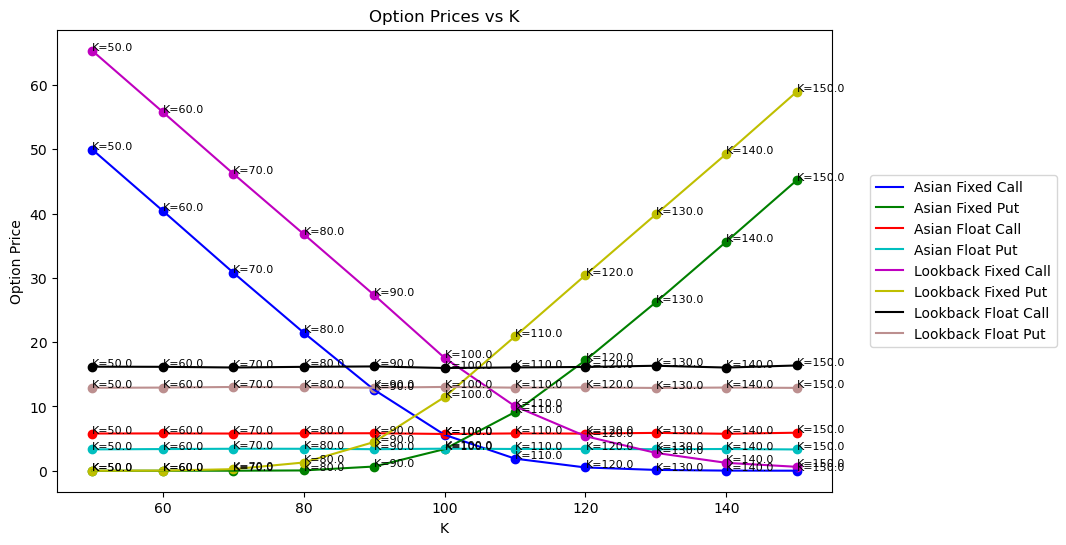

In [245]:
param_name = "K"
param_values = np.linspace(50, 150, 10 + 1)  # an equidistant list of 10 values for K from 50 to 150
option_prices = []
for param_value in param_values:
    op = OptionPricer(S0=100, K=param_value, r=0.05, t=1, dt=0.01, sigma=0.2, number_of_mc_paths=20000)
    option_prices.append(op.calculate_option_prices())
plot_option_prices_vs_param(param_name, param_values, option_prices)

**ADD ANALYSIS FOR STRIKE**

#### 5.4 Impact analysis of risk-free rate $r$

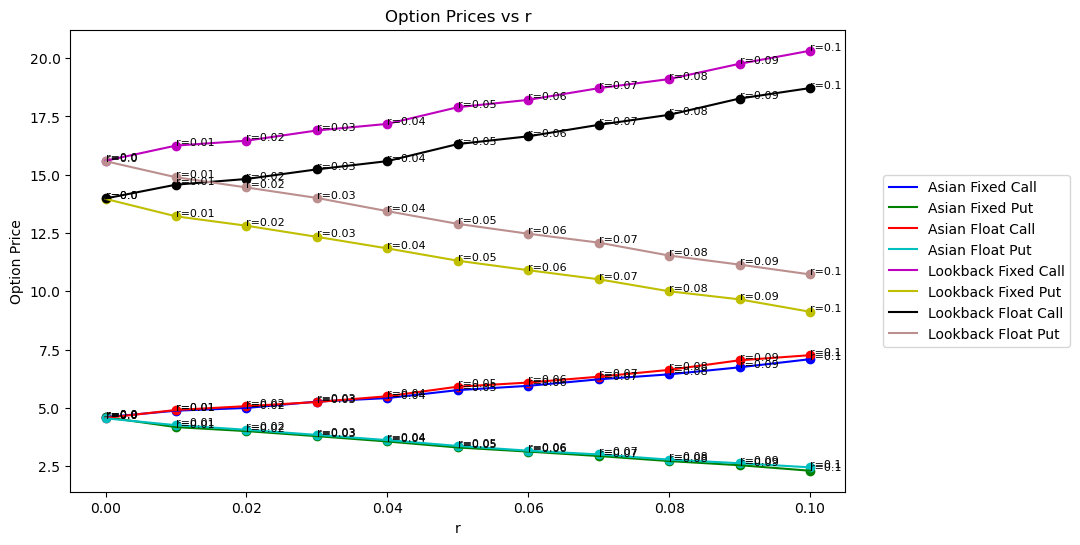

In [241]:
param_name = "r"
param_values = np.linspace(0, 0.1, 10 + 1)  # an equidistant list of 10 values for r from 0% to 10%
option_prices = []
for param_value in param_values:
    op = OptionPricer(S0=100, K=100, r=param_value, t=1, dt=0.01, sigma=0.2, number_of_mc_paths=20000)
    option_prices.append(op.calculate_option_prices())
plot_option_prices_vs_param(param_name, param_values, option_prices, log_x_axis=False)

**ADD ANALYSIS FOR RFR**

#### 5.5 Impact analysis of time to expiry $T-t$

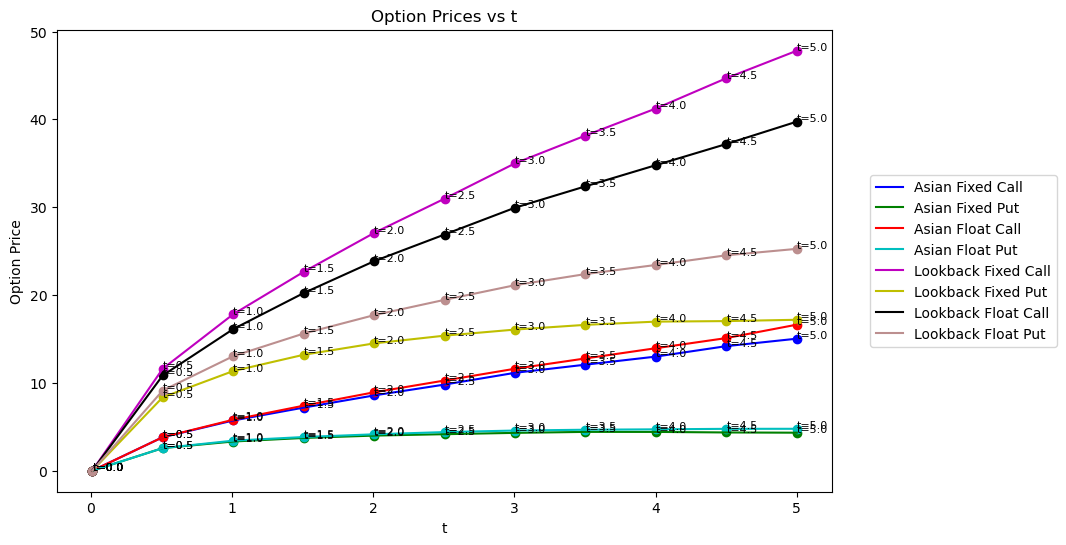

In [242]:
param_name = "t"
param_values = np.linspace(0.01, 5, 10 + 1)  # an equidistant list of 10 values for t (time to expiry) from 0 to 1 year
option_prices = []
for param_value in param_values:
    op = OptionPricer(S0=100, K=100, r=0.05, t=param_value, dt=0.01, sigma=0.2, number_of_mc_paths=20000)
    option_prices.append(op.calculate_option_prices())
plot_option_prices_vs_param(param_name, param_values, option_prices, annotation_precision=1)

**ADD ANALYSIS FOR TIME TO EXP**

#### 5.6 Impact analysis of time step $\delta t$

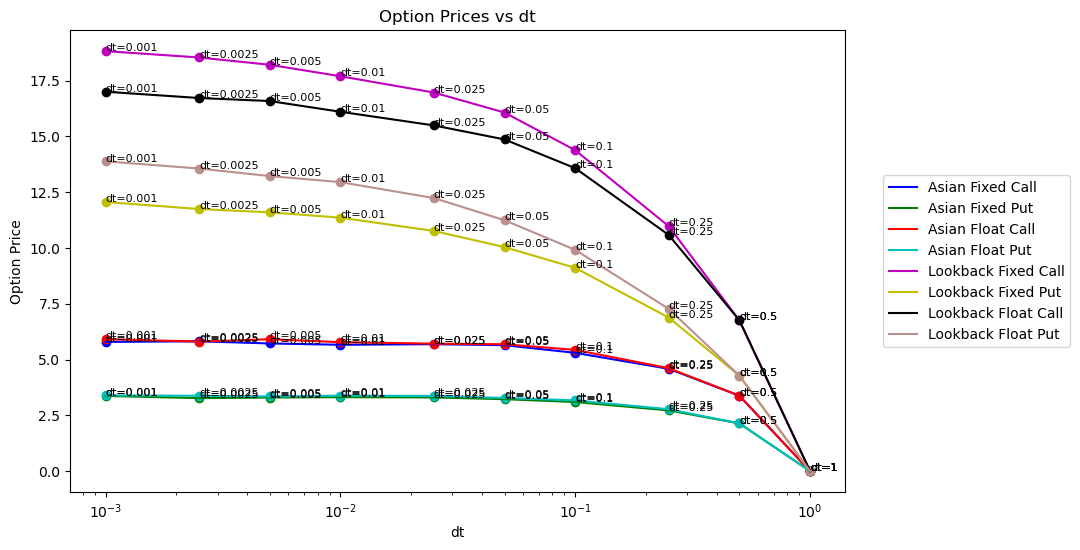

In [243]:
param_name = "dt"
param_values = [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]
option_prices = []
for param_value in param_values:
    op = OptionPricer(S0=100, K=100, r=0.05, t=1, dt=param_value, sigma=0.2, number_of_mc_paths=20000)
    option_prices.append(op.calculate_option_prices())
plot_option_prices_vs_param(param_name, param_values, option_prices, annotation_precision=4, log_x_axis=True)

**ADD ANALYSIS**

#### 5.7 Impact analysis of volatility $\sigma$

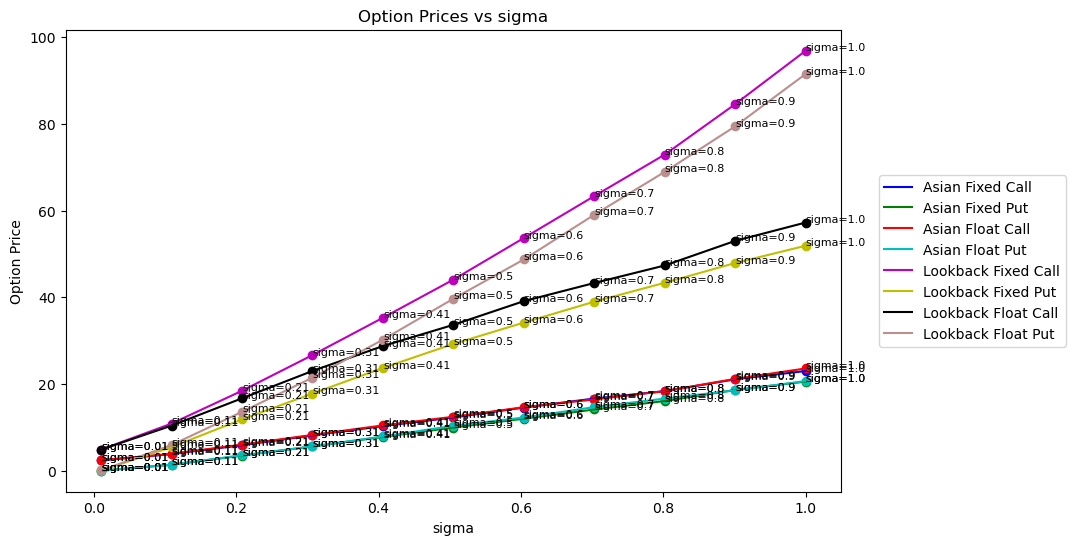

In [244]:
param_name = "sigma"
param_values = np.linspace(0.01, 1, 10 + 1)  # an equidistant list of 10 values for sigma from 1% to 100%
option_prices = []
for param_value in param_values:
    op = OptionPricer(S0=100, K=100, r=0.05, t=1, dt=0.01, sigma=param_value, number_of_mc_paths=20000)
    option_prices.append(op.calculate_option_prices())
plot_option_prices_vs_param(param_name, param_values, option_prices)

**ADD ANALYSIS**

## References

* [1]: JA243.4: Lecture Notes on Numerical Methods by Dr. Riaz Ahmad, CQF Faculty, Head of Faculty
* [2]: JA24 Monte Carlo Simulation: CQF Python Labs on Monte Carlo Simulation by Kannan Singaravelu
* [3]: Willmott, Paul - _Paul Willmott on Quantitative Finance_, Second Edition, Volume 2, p. 427-452, Wiley, 2006